In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load CIFAR-10 dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Define a convolutional neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Set up a list of optimization algorithms to test
optimizers = ['SGD', 'ASGD', 'Adadelta', 'Adam', 'Adamax', 'RMSprop']

[1,  2000] loss: 2.260
[1,  4000] loss: 1.964
[1,  6000] loss: 1.732
[1,  8000] loss: 1.653
[1, 10000] loss: 1.555
[1, 12000] loss: 1.506
[2,  2000] loss: 1.431
[2,  4000] loss: 1.402
[2,  6000] loss: 1.384
[2,  8000] loss: 1.356
[2, 10000] loss: 1.348
[2, 12000] loss: 1.307
[3,  2000] loss: 1.241
[3,  4000] loss: 1.233
[3,  6000] loss: 1.224
[3,  8000] loss: 1.194
[3, 10000] loss: 1.213
[3, 12000] loss: 1.204
[4,  2000] loss: 1.111
[4,  4000] loss: 1.111
[4,  6000] loss: 1.134
[4,  8000] loss: 1.100
[4, 10000] loss: 1.124
[4, 12000] loss: 1.131
[5,  2000] loss: 1.030
[5,  4000] loss: 1.057
[5,  6000] loss: 1.039
[5,  8000] loss: 1.055
[5, 10000] loss: 1.049
[5, 12000] loss: 1.037
[1,  2000] loss: 2.194
[1,  4000] loss: 1.886
[1,  6000] loss: 1.696
[1,  8000] loss: 1.581
[1, 10000] loss: 1.540
[1, 12000] loss: 1.503
[2,  2000] loss: 1.447
[2,  4000] loss: 1.396
[2,  6000] loss: 1.386
[2,  8000] loss: 1.331
[2, 10000] loss: 1.335
[2, 12000] loss: 1.311
[3,  2000] loss: 1.256
[3,  4000] 

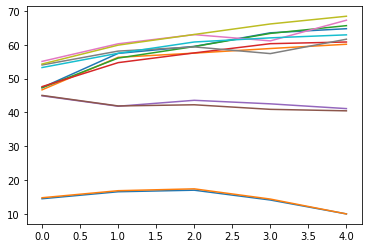

In [7]:
# Train and test each optimization algorithm
for optimizer in optimizers:
  # Initialize the model and optimizer
  net = Net().to(device)
  criterion = nn.CrossEntropyLoss()
  if optimizer == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  elif optimizer == 'ASGD':
    optimizer = optim.ASGD(net.parameters(), lr=0.01, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
  elif optimizer == 'Adadelta':
    optimizer = optim.Adadelta(net.parameters(), rho=0.9, eps=1e-06, weight_decay=0)
  elif optimizer == 'Adam':
    optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
  elif optimizer == 'Adamax':
    optimizer = optim.Adamax(net.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
  elif optimizer == 'RMSprop':
    optimizer = optim.RMSprop(net.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)

  # Initialize lists to store training and testing accuracy for each epoch
  train_accuracies = []
  test_accuracies = []

  # Train the model for 5 epochs. if you want more accuracy increase the epochs
  for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # Get inputs and labels
      inputs, labels = data[0].to(device), data[1].to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = net(inputs)
      loss = criterion(outputs, labels)

      # Backward pass
      loss.backward()

      # Optimize
      optimizer.step()

      # Print statistics
      running_loss += loss.item()
      if i % 2000 == 1999:
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

    # Calculate training accuracy
    correct = 0
    total = 0
    with torch.no_grad():
      for data in trainloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_accuracies.append(100 * correct / total)

    # Calculate test accuracy
    correct = 0
    total = 0
    with torch.no_grad():
      for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    test_accuracies.append(100 * correct / total)

  # Plot the training and test accuracies
  plt.plot(train_accuracies, label='{} (train)'.format(optimizer))
  plt.plot(test_accuracies, label='{} (test)'.format(optimizer))


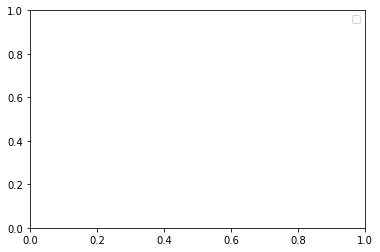

In [20]:
# Add a legend and show the plot
plt.legend()
plt.show()